In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import load_model
import keras.backend as K
from util import get_model
from extract_artifacts import get_lid
import collections
from detect_adv_samples import detect


import cifar10_input

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = get_model("cifar", softmax=True)
model.load_weights("data/lid_model_cifar.h5")
model_logits = get_model("cifar", softmax=False)
model_logits.load_weights("data/lid_model_cifar.h5")


In [3]:
class Attack:
    def __init__(self, model, tol, num_steps, step_size, random_start):
        self.model = model
        self.tol = tol
        self.num_steps = num_steps
        self.step_size = step_size
        self.rand = random_start

        self.xs = tf.Variable(np.zeros((1000, 32, 32, 3), dtype=np.float32),
                                    name='modifier')
        self.orig_xs = tf.placeholder(tf.float32, [None, 32, 32, 3])

        self.ys = tf.placeholder(tf.int32, [None])

        self.epsilon = 8.0/255

        delta = tf.clip_by_value(self.xs, 0, 255) - self.orig_xs
        delta = tf.clip_by_value(delta, -self.epsilon, self.epsilon)

        self.do_clip_xs = tf.assign(self.xs, self.orig_xs+delta)

        self.logits = logits = model(self.xs)

        label_mask = tf.one_hot(self.ys, 10)
        correct_logit = tf.reduce_sum(label_mask * logits, axis=1)
        wrong_logit = tf.reduce_max((1-label_mask) * logits - 1e4*label_mask, axis=1)

        self.loss = (correct_logit - wrong_logit)

        start_vars = set(x.name for x in tf.global_variables())
        optimizer = tf.train.AdamOptimizer(step_size*1)

        grad,var = optimizer.compute_gradients(self.loss, [self.xs])[0]
        self.train = optimizer.apply_gradients([(tf.sign(grad),var)])

        end_vars = tf.global_variables()
        self.new_vars = [x for x in end_vars if x.name not in start_vars]

    def perturb(self, x, y, sess):
        sess.run(tf.variables_initializer(self.new_vars))
        sess.run(self.xs.initializer)
        sess.run(self.do_clip_xs,
                 {self.orig_xs: x})

        for i in range(self.num_steps):

            sess.run(self.train, feed_dict={self.ys: y})
            sess.run(self.do_clip_xs,
                     {self.orig_xs: x})

        return sess.run(self.xs)

cifar = cifar10_input.CIFAR10Data("../cifar10_data")

sess = K.get_session()
attack = Attack(model_logits,
                      1,
                      100,
                      1/255.0,
                      False)


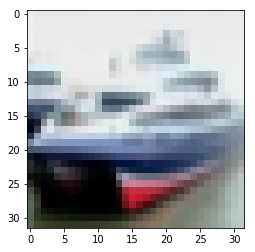

Image Label 8
Clean Model Prediction 8
Clean Model Logits [[ -4.3375077   0.3012276 -12.330709  -11.296892  -15.26732   -13.380332
  -11.1896    -16.897142    8.292903   -6.16642  ]]


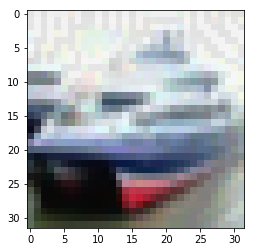

Max distortion 0.03137256374546127
Adversarial Model Prediction 1
Adversarial Model Logits [[ -8.697777   11.830964  -14.309156  -12.301084  -18.515553  -12.888949
  -10.960991  -18.23993    -4.2297196  -1.2803907]]


In [4]:
xs = tf.placeholder(tf.float32, (1, 32, 32, 3))

image = cifar.eval_data.xs[:1000]/255.0-.5
label = cifar.eval_data.ys[:1000]

plt.imshow(image[1]+.5)
plt.show() 
print("Image Label", label[1])

x_input = tf.placeholder(tf.float32, [None, 32, 32, 3])
logits = model_logits(x_input)

print('Clean Model Prediction', np.argmax(sess.run(logits, {x_input: image[1:2]})))
print('Clean Model Logits', sess.run(logits, {x_input: image[1:2]}))


adversarial = attack.perturb(image, label, sess)

plt.imshow(adversarial[1]+.5)
plt.show()

print("Max distortion", np.max(np.abs(adversarial-image)))

print('Adversarial Model Prediction', np.argmax(sess.run(logits, {x_input: adversarial[1:2]})))
print('Adversarial Model Logits', sess.run(logits, {x_input: adversarial[1:2]}))


In [5]:
artifacts, labels = get_lid(model, image, image, adversarial, 20, 100, 'cifar')

  0%|          | 0/10 [00:00<?, ?it/s]

Extract local intrinsic dimensionality: k = 20
Number of layers to estimate:  26
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


 10%|█         | 1/10 [00:06<00:57,  6.37s/it]

25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


 20%|██        | 2/10 [00:11<00:46,  5.78s/it]

24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


 30%|███       | 3/10 [00:16<00:39,  5.66s/it]

24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


 40%|████      | 4/10 [00:22<00:33,  5.65s/it]

24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


 50%|█████     | 5/10 [00:27<00:27,  5.56s/it]

25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


 60%|██████    | 6/10 [00:33<00:22,  5.64s/it]

22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


 70%|███████   | 7/10 [00:38<00:16,  5.57s/it]

21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


 80%|████████  | 8/10 [00:44<00:11,  5.58s/it]

25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


 90%|█████████ | 9/10 [00:50<00:05,  5.62s/it]

21
22
23
24
25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21


100%|██████████| 10/10 [00:56<00:00,  5.63s/it]

22
23
24
25
lids_normal: (1000, 26)
lids_noisy: (1000, 26)
lids_adv: (1000, 26)
X_pos:  (1000, 26)
X_neg:  (2000, 26)


In [6]:
from detect_adv_samples import detect

T = collections.namedtuple('args', ['dataset', 'attack', 'artifacts', 'test_attack'])
lr, _, scaler = detect(T('cifar', 'cw-l2', 'lid', 'cw-l2'))

t_artifacts = scaler.transform(artifacts)

print('Detection rate clean', np.mean(lr.predict(t_artifacts[:1000])))
print('Detection rate adversarial', np.mean(lr.predict(t_artifacts[-1000:])))

  -- lid
Isolated split 80%, 20% for training and testing
Train samples size:  (19800, 26)
Test samples size:  (4968, 26)
LR Detector on [dataset: cifar, train_attack: cw-l2, test_attack: cw-l2] with:
Detector ROC-AUC score: 0.9737, accuracy: 0.9257
Detection rate clean 0.026
Detection rate adversarial 0.044
